# Analytics in E-commerce (RFM Analysis)

In [2]:
# import the libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the dataset 
data = pd.read_excel('Superstore.xlsm')
# Display the first few rows of the dataset
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
# Check for missing values
data.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [5]:
# Convert Order Date and Ship Date to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

In [6]:
# Display the basic statistics of the dataset
data.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


Calculate Recency, Frequency, and Monetary Values

In [7]:
# Define the reference date
reference_date = data['Order Date'].max() + dt.timedelta(days=1)

In [8]:
# Calculate Recency, Frequency, and Monetary values for each customer
rfm = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).reset_index()

In [9]:
# Rename the columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

In [10]:
# Ensure the columns are numeric
rfm['Recency'] = pd.to_numeric(rfm['Recency'], errors='coerce')
rfm['Frequency'] = pd.to_numeric(rfm['Frequency'], errors='coerce')
rfm['Monetary'] = pd.to_numeric(rfm['Monetary'], errors='coerce')

In [11]:
# Calculate quantiles for RFM values
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile(q=[0.2, 0.4, 0.6, 0.8])
print(quantiles)

     Recency  Frequency   Monetary
0.2     27.0        4.0   961.5406
0.4     54.0        5.0  1739.4324
0.6    104.0        7.0  2750.7480
0.8    225.6        8.6  4282.6344


Generate RFM Scores

In [12]:
# Define a function to calculate RFM scores
def rfm_score(x, quantiles):
    if x <= quantiles[0.2]:
        return 5
    elif x <= quantiles[0.4]:
        return 4
    elif x <= quantiles[0.6]:
        return 3
    elif x <= quantiles[0.8]:
        return 2
    else:
        return 1

In [13]:
# Apply the function to each RFM column
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'],))
rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'],))
rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'],))

In [14]:
# Combine R, F, and M scores into a single RFM score
rfm['RFM_Score'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)

In [15]:
# Display the RFM scores
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,AA-10315,185,5,5563.560,2,4,1,241
1,AA-10375,20,9,1056.390,5,1,4,514
2,AA-10480,260,4,1790.512,1,5,3,153
3,AA-10645,56,6,5086.935,3,3,1,331
4,AB-10015,416,3,886.156,1,5,5,155


Segment the Customers

In [16]:
# Define a function to segment customers based on RFM score
def segment_customer(df):
    if df['RFM_Score'] == '555':
        return 'Best Customers'
    elif df['R_Score'] == 5:
        return 'Loyal Customers'
    elif df['F_Score'] == 5:
        return 'Frequent Customers'
    elif df['M_Score'] == 5:
        return 'High Spending Customers'
    else:
        return 'Others'

In [17]:
# Apply the function to create a new column 'Segment'
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [18]:
# Display the segmented customers
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,AA-10315,185,5,5563.560,2,4,1,241,Others
1,AA-10375,20,9,1056.390,5,1,4,514,Loyal Customers
2,AA-10480,260,4,1790.512,1,5,3,153,Frequent Customers
3,AA-10645,56,6,5086.935,3,3,1,331,Others
4,AB-10015,416,3,886.156,1,5,5,155,Frequent Customers


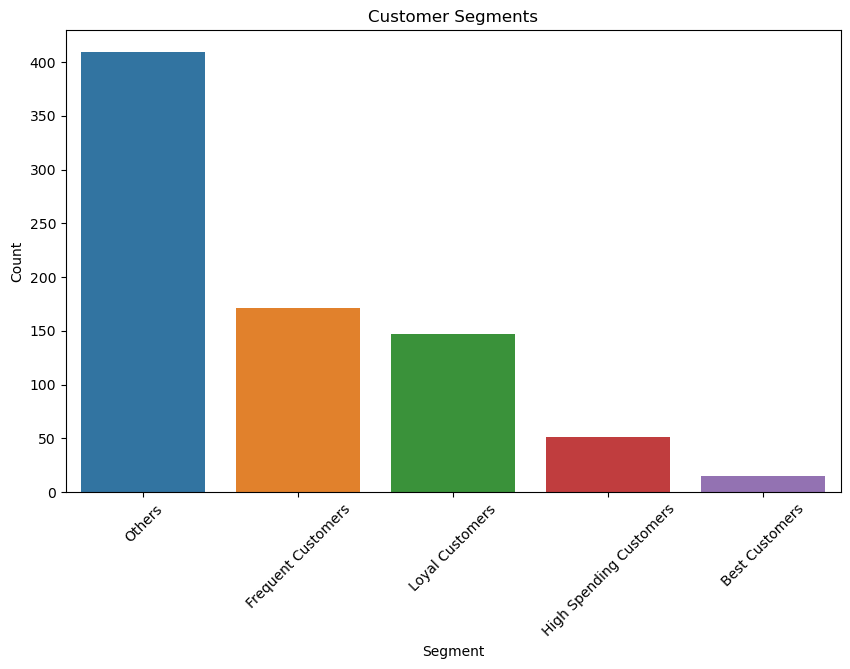

In [19]:
# Plot the segments
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()